## Midterm - Adam with HW1 - Sine curve regression
### Shailesh Patro

I have implemented an Adam optimizer based on *ADAM: A METHOD FOR STOCHASTIC OPTIMIZATION* by Diederik P. Kingma & Jimmy Lei Ba         
(https://arxiv.org/pdf/1412.6980v8.pdf). 
The implementation uses Keras base class and common methods for compatbility with a keras model. The keras compatibility is preferable for testing the optimizer quickly on several datasets.

I have tested the optimizer on three data sets:

1.   Sine Curve Regression
2.   MNIST Classification
3.   AG News data Classification





In [1]:
import pandas as pd
import keras
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Conv1D, BatchNormalization, Activation,Flatten
from keras.layers import Embedding, Input, Dense, Dropout, Lambda, MaxPooling1D
from keras.optimizers import SGD
from keras.models import Model

from keras.optimizers import Optimizer


Using TensorFlow backend.


In [0]:
class AdamOptimizer(Optimizer):
  def __init__(self, alpha=0.001, beta_1=0.9,
               beta_2=0.999, epsilon=1e-08, 
               **kwargs):
    super(AdamOptimizer, self).__init__(**kwargs)
    with keras.backend.name_scope(self.__class__.__name__):
      self.iterations = keras.backend.variable(0, dtype='int64', name='iterations')
      # alpha is the stepsize/learning rate as described in the paper
      self.alpha = keras.backend.variable(alpha, name='alpha')
      # beta_1, beta_2 are the exponential decay rates for the moment estimates
      self.beta_1 = keras.backend.variable(beta_1, name='beta_1')
      self.beta_2 = keras.backend.variable(beta_2, name='beta_2')
      self.epsilon = epsilon
 


  def get_updates(self, loss, params):
    xs = params
    # get gradients with tensorflow's built in gradient function
    grads = tf.gradients(loss, xs, colocate_gradients_with_ops=True)
    self.updates = [tf.assign_add(self.iterations, 1)]
    # alpha is the learning rate as defined in the paper
    alpha = self.alpha
    # increment timestep by 1
    t = tf.cast(self.iterations, 'float32') + 1
    
    # suggested improvement as mentioned in section 2: algorithm
    alpha_t = alpha * (tf.sqrt(1. - tf.pow(self.beta_2, t)) / (1. - tf.pow(self.beta_1, t))) 
    
    # initialize m, v to zero
    ms = [keras.backend.zeros(x.shape, dtype=x.dtype.base_dtype.name) for x in xs]
    vs = [keras.backend.zeros(x.shape, dtype=x.dtype.base_dtype.name) for x in xs]
 
    self.weights = [self.iterations] + ms + vs
    
    for x, g, m, v in zip(xs, grads, ms, vs):
        # Update biased first moment estimate
        m_t = (self.beta_1 * m) + (1. - self.beta_1) * g
        
        # Update biased second raw moment estimate 
        # also used tensorflow's elementwise square
        v_t = (self.beta_2 * v) + (1. - self.beta_2) * tf.square(g) 
        
        # Update Parameters
        x_t = x - alpha_t * m_t / (tf.sqrt(v_t) + self.epsilon)
        self.updates.append(tf.assign(m, m_t))
        self.updates.append(tf.assign(v, v_t))
        new_x = x_t

        self.updates.append(tf.assign(x, new_x))
    return self.updates

  
  
  def get_config(self):
    config = {'alpha': float(keras.backend.get_value(self.alpha)),
              'beta_1': float(keras.backend.get_value(self.beta_1)),
              'beta_2': float(keras.backend.get_value(self.beta_2)),
              'epsilon': self.epsilon}
    base_config = super(AdamOptimizer, self).get_config()
    return dict(list(base_config.items()) + list(config.items()))
  

In [31]:
## list inputs

N = 100 # Sample size
# M = 6 # number of gaussian basis functions
# iteration = 1000 # else recognized as number of batches
# learning_rate = 0.01 # the eta in newton's method
sigma = 0.1 # noise in data

## sample data points from a sine wave 
x_vals = np.random.uniform(0.0, 1.0, N) # A sort may make this easy to graph this later
y_vals = np.sin(np.pi*2*x_vals) + np.random.normal(0, sigma, N) # noisy

model = Sequential()
model.add(Dense(40, activation='tanh', input_shape=(1,)))
model.add(Dense(12, activation = 'tanh'))
model.add(Dense(1, activation = 'tanh'))
adamopt = AdamOptimizer()
model.compile(optimizer=adamopt, loss='mse', metrics = ['mean_squared_error'])
model.fit(x_vals,y_vals, epochs=1000, batch_size=8, verbose=1)

Epoch 1/1000
100/100 [==============================] - 1s 7ms/step - loss: 0.4686 - mean_squared_error: 0.4686
Epoch 2/1000
100/100 [==============================] - 0s 213us/step - loss: 0.4218 - mean_squared_error: 0.4218
Epoch 3/1000
100/100 [==============================] - 0s 200us/step - loss: 0.3832 - mean_squared_error: 0.3832
Epoch 4/1000
100/100 [==============================] - 0s 211us/step - loss: 0.3474 - mean_squared_error: 0.3474
Epoch 5/1000
100/100 [==============================] - 0s 206us/step - loss: 0.3148 - mean_squared_error: 0.3148
Epoch 6/1000
100/100 [==============================] - 0s 221us/step - loss: 0.2830 - mean_squared_error: 0.2830
Epoch 7/1000
100/100 [==============================] - 0s 219us/step - loss: 0.2600 - mean_squared_error: 0.2600
Epoch 8/1000
100/100 [==============================] - 0s 203us/step - loss: 0.2374 - mean_squared_error: 0.2374
Epoch 9/1000
100/100 [==============================] - 0s 209us/step - loss: 0.2186 - mea

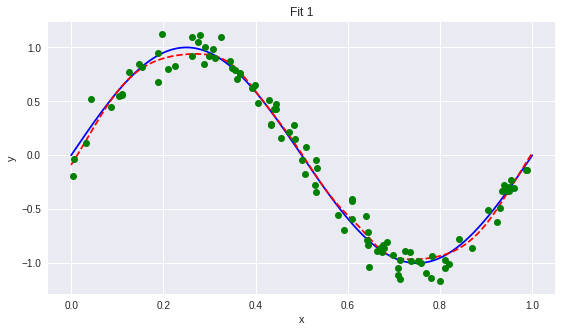

In [32]:
figure = plt.figure(figsize=(20,5))

p = plt.subplot(1,2,1)
x_np = np.linspace(0, 1, 500)
# y_np = []
# print(model.predict(x_np))
y_np = model.predict(x_np)


p.plot(x_np, np.sin(2*np.pi*x_np), "b")
p.plot(x_np, y_np, 'r--')
p.plot(x_vals, y_vals, 'go')
p.set_xlabel('x')
p.set_ylabel('y')
p.set_title('Fit 1')

plt.show()

